# `Pca- Online, Oja's algorithm`

# Q1

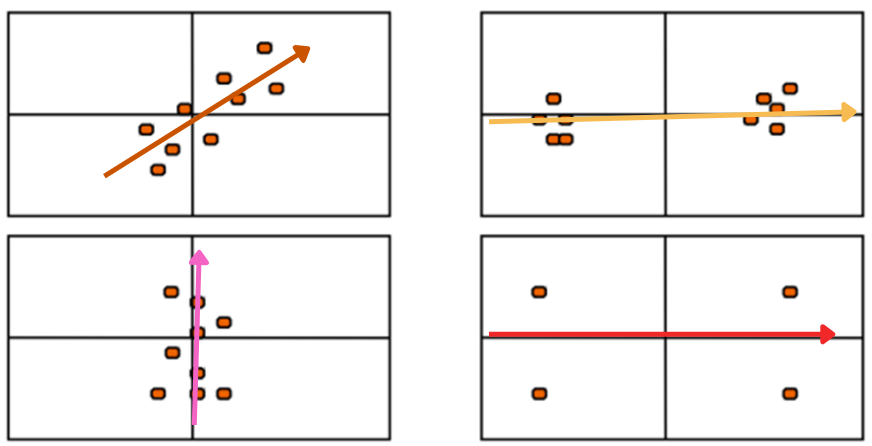

# Q2- at the bottom of the file

We're going to implement an online method for PCA computation- Oja's algorithm. This algorithm represents the communications and connections between neurons and synapses. An online algorithm is a realistic approach for a biological system- we update our state based on the previous information, without storing all the information in a hidden storage.
In addition, We're going to compare this method to a straight forward offline approach for PCA. Lastly, we'll prohect the data to our principle components. 

In [15]:
import numpy as np
from numpy.linalg import norm
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [710]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define the three distributions
distributions = [
    {"mean": np.array([-10, 10, -10]), "cov": np.eye(3)},
    {"mean": np.array([-10, -10, -10]), "cov": np.eye(3)},
    {"mean": np.array([20, 0, 20]), "cov": np.eye(3)}
]

def generate_sample():
   
    dist_index = random.choice(range(len(distributions)))
    dist = distributions[dist_index]
    x = np.random.multivariate_normal(mean=dist["mean"], cov=dist["cov"])
    return x, dist_index

def ojas_algorithm(
    learning_rate=0.001,
    epsilon=1e-6,
    max_iterations=1000000,
    verbose=True):
 
    
    reconstruction_error_list = []
    x_list = []
    labels_list = []
    W_list_m = []
    delta_norm_list = []
    w = np.random.randn(3)
    w /= np.linalg.norm(w)

    if verbose:
        iterator = tqdm(range(max_iterations), desc="Training Oja's Algorithm")
    else:
        iterator = range(max_iterations)

    for i in iterator:
        x, label = generate_sample()
        x_list.append(x)
        labels_list.append(label)
        y = np.dot(w, x)     
        delta_w = learning_rate * y * (x - y * w)
        delta_norm_list.append(np.linalg.norm(delta_w))
        w += delta_w   
        #print(delta_w,w)
        W_list_m.append(w.copy()) 
            
        w /= np.linalg.norm(w)    # Normalize to prevent weight explosion
        

        # Prediction (Reconstruction) Error
        reconstruction_error = 0.5 * np.linalg.norm(x - y * w)**2
        reconstruction_error_list.append(reconstruction_error)

        # Check for convergence based on weight update magnitude
        if np.linalg.norm(delta_w) < epsilon:
            if verbose:
                print(f"Converged after {i+1} iterations.")
            return w, i+1, x_list, reconstruction_error_list, labels_list, W_list_m,delta_norm_list

    if verbose:
        print(f"Reached maximum iterations ({max_iterations}) without full convergence.")
    return w, max_iterations, x_list, reconstruction_error_list, labels_list, W_list_m,delta_norm_list

def compute_reconstruction_error(w, num_samples=10000):
    """
    Computes the average reconstruction error over a set of samples.

    Parameters:
    - w: Weight vector (principal component).
    - num_samples: Number of samples to generate for error computation.

    Returns:
    - average_error: The mean squared reconstruction error.
    """
    errors = []
    for _ in range(num_samples):
        x, _ = generate_sample()
        y = np.dot(w, x)
        x_hat = y * w
        error = np.linalg.norm(x - x_hat)**2
        errors.append(error)
    average_error = np.mean(errors)
    return average_error




In [870]:
# Hyperparameters

learning_rate = 0.001
epsilon = 3e-5
max_iterations = 500000 

# Train the neuron using Oja's algorithm
w, num_iterations, x_list, reconstruction_error_list, labels_list, W_list,delta_norm_list = ojas_algorithm(
    learning_rate=learning_rate,
    epsilon=epsilon,
    max_iterations=max_iterations,
    verbose=True
)

print(f"\nLearned weight vector (principal component):\n{w}")

# Compute the reconstruction error on a test set
#test_error = compute_reconstruction_error(w, num_samples=100000)
print(f"Average Reconstruction Error on Test Set: {test_error:.4f}\n")

# Convert lists to numpy arrays for efficient processing
x_array = np.array(x_list)
labels_array = np.array(labels_list)

# Plot the data and the weight vector




Training Oja's Algorithm: 100%|██████████| 500000/500000 [00:26<00:00, 18968.21it/s]


Reached maximum iterations (500000) without full convergence.

Learned weight vector (principal component):
[-0.72586799 -0.0020199  -0.68783107]
Average Reconstruction Error on Test Set: 76.1681



In [939]:
from scipy.spatial import Delaunay, ConvexHull
import numpy as np
import matplotlib.pyplot as plt

def is_point_in_hull(point, hull):
    """
    Check if a point lies inside the convex hull.

    Parameters:
    - point: A 3D point to check (numpy array)
    - hull: A ConvexHull or Delaunay object

    Returns:
    - True if the point is inside the hull, False otherwise
    """
    if isinstance(hull, ConvexHull):
        hull = Delaunay(hull.points[hull.vertices])  # Convert ConvexHull to Delaunay for point checking
    return hull.find_simplex(point) >= 0

def get_secondary_direction(w_normalized):

    # Define the z-axis
    z_axis = np.array([0, 0, 1])
    
    # Check if w_normalized is parallel to z-axis
    if np.allclose(w_normalized, z_axis) or np.allclose(w_normalized, -z_axis):
        # If parallel, use y-axis to compute secondary direction
        y_axis = np.array([0, 1, 0])
        secondary_dir = np.cross(w_normalized, y_axis)
    else:
        # Otherwise, use z-axis
        secondary_dir = np.cross(w_normalized, z_axis)
    
    # Normalize the secondary direction
    secondary_dir /= np.linalg.norm(secondary_dir)
    
    return secondary_dir

def plot_3d_data_and_weights(data, labels, w):
 
    fig = plt.figure(figsize=(15, 10))

    # Normalize the principal component vector
    w_normalized = w / np.linalg.norm(w)

    # Compute secondary direction for determining 'Above' or 'Below'
    secondary_dir = get_secondary_direction(w_normalized)

    # 3D Scatter Plot
    ax1 = fig.add_subplot(121, projection='3d')

    # Define colors for each distribution
    colors = ['r', 'g', 'b']
    colors_dark = ['maroon', 'darkgreen', 'darkblue']

    # Extract data for each cluster and calculate their convex hulls
    clusters = {
        'Red': {'color': 'r', 'dark_color': 'maroon', 'data': data[labels == 0]},
        'Green': {'color': 'g', 'dark_color': 'darkgreen', 'data': data[labels == 1]},
        'Blue': {'color': 'b', 'dark_color': 'darkblue', 'data': data[labels == 2]}
    }

    # Plot all clusters with transparency
    for cluster_name, cluster_info in clusters.items():
        cluster_data = cluster_info['data']
        if len(cluster_data) == 0:
            print(f"No data points found for {cluster_name} cluster.")
            continue
        ax1.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],
                    c=cluster_info['color'], alpha=0.3, label=f'{cluster_name} Cluster', s=20)

    # Compute and plot convex hulls for each cluster
    for cluster_name, cluster_info in clusters.items():
        cluster_data = cluster_info['data']
        if len(cluster_data) < 4:
            print(f"Not enough points to compute ConvexHull for {cluster_name} cluster.")
            continue
        try:
            hull = ConvexHull(cluster_data)
            for simplex in hull.simplices:
                ax1.plot(cluster_data[simplex, 0], cluster_data[simplex, 1],
                         cluster_data[simplex, 2], f'{cluster_info["color"]}--', alpha=0.5)
        except Exception as e:
            print(f"ConvexHull for {cluster_name} cluster could not be computed: {e}")

    # Plot the principal component line
    max_range = np.max(np.abs(data)) * 1.2  # Slightly larger than data range
    line_points = np.linspace(-max_range, max_range, 100)
    pc_line = np.outer(line_points, w_normalized)

    ax1.plot(pc_line[:, 0], pc_line[:, 1], pc_line[:, 2],
             color='k', linewidth=2, label='Principal Component')

    # Compute projections
    projections = np.outer(np.dot(data, w_normalized), w_normalized)

    # Plot lines connecting data points to their projections, color-coded by cluster
    for i in range(len(data)):
        cluster_idx = labels[i]
        # Identify cluster name based on index
        cluster_name = ['Red', 'Green', 'Blue'][cluster_idx]
        cluster_dark_color = clusters[cluster_name]['dark_color']
        ax1.plot([data[i, 0], projections[i, 0]],
                 [data[i, 1], projections[i, 1]],
                 [data[i, 2], projections[i, 2]],
                 c=cluster_dark_color, alpha=0.05, linewidth=1)

    # Check if the principal component vector intersects any of the convex hulls
    intersects = {}
    for cluster_name, cluster_info in clusters.items():
        cluster_data = cluster_info['data']
        if len(cluster_data) < 4:
            intersects[cluster_name] = False
            continue
        hull = ConvexHull(cluster_data)
        hull_delaunay = Delaunay(cluster_data[hull.vertices])
        # Check if any point on the principal component line is inside the convex hull
        intersects_cluster = np.any([hull_delaunay.find_simplex(point) >= 0 for point in pc_line])
        intersects[cluster_name] = intersects_cluster

    # Compute centroids for each cluster
    centroids = {}
    for cluster_name, cluster_info in clusters.items():
        cluster_data = cluster_info['data']
        if len(cluster_data) == 0:
            centroids[cluster_name] = None
        else:
            centroids[cluster_name] = cluster_data.mean(axis=0)

    # Determine 'Above' or 'Below' for each cluster and print statements
    for cluster_name, centroid in centroids.items():
        if centroid is None:
            continue
        # Project centroid onto secondary direction
        projection_value = np.dot(centroid, secondary_dir)
        if projection_value > 0:
            position = 'Above'
        elif projection_value < 0:
            position = 'Below'
        else:
            position = 'On'
        
        # Check intersection
        if intersects.get(cluster_name, False):
            print(f"Part of the principal component vector is inside the {cluster_name.lower()} cluster.")
            print(f"Part of the {cluster_name.lower()} cluster is NOT intersecting and is {position} the principal component vector.\n")
        else:
            print(f"The {cluster_name.lower()} cluster is entirely NOT intersecting and is {position} the principal component vector.\n")

    # Set plot titles and labels
    ax1.set_title("Data Points, Convex Hulls, and Principal Component")
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    ax1.set_zlabel('Z3')
    ax1.legend()

    # Adjust the viewing angle
    ax1.view_init(elev=20, azim=40)

    # Set equal aspect ratio for all axes
    ax1.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()


The red cluster is entirely NOT intersecting and is Above the principal component vector.

The green cluster is entirely NOT intersecting and is Below the principal component vector.

Part of the principal component vector is inside the blue cluster.
Part of the blue cluster is NOT intersecting and is Below the principal component vector.



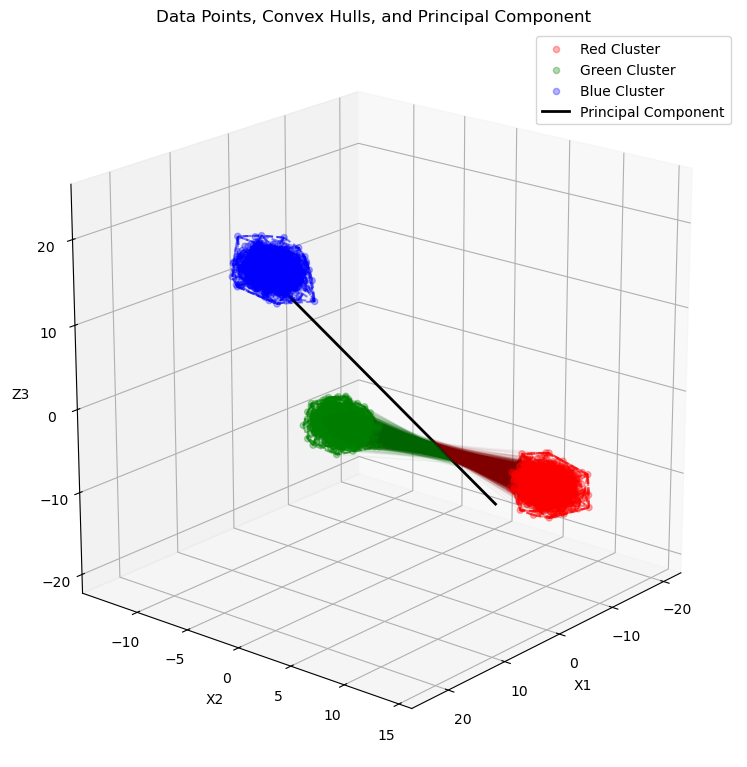

In [940]:
plot_3d_data_and_weights(x_array[::50], labels_array[::50], w)


Text(0.5, 1.0, 'Reconstruction Error over time')

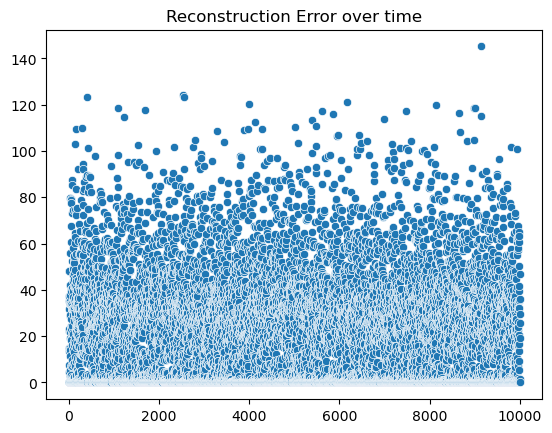

In [946]:
sns.scatterplot(reconstruction_error_list[::50])
plt.title('Reconstruction Error over time')

Text(0.5, 1.0, 'Reconstruction Error last 100 iterations')

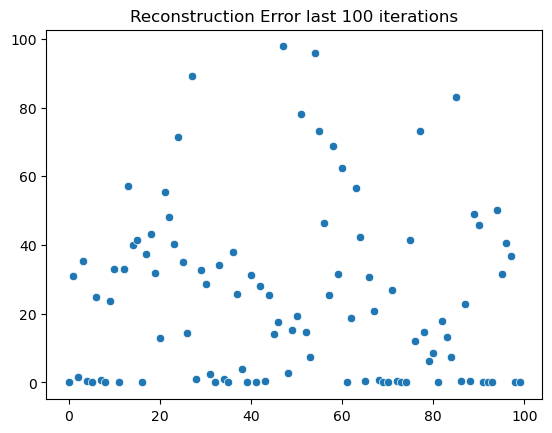

In [942]:
sns.scatterplot(reconstruction_error_list[len(reconstruction_error_list)-100:])
plt.title('Reconstruction Error last 100 iterations')

Text(0.5, 1.0, 'Delta Norm over time')

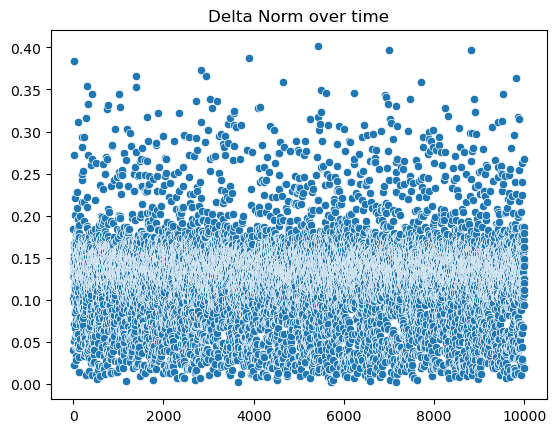

In [947]:
sns.scatterplot(delta_norm_list[::50])
plt.title('Delta Norm over time')

Text(0.5, 1.0, 'Delta Norm last 100 iterations')

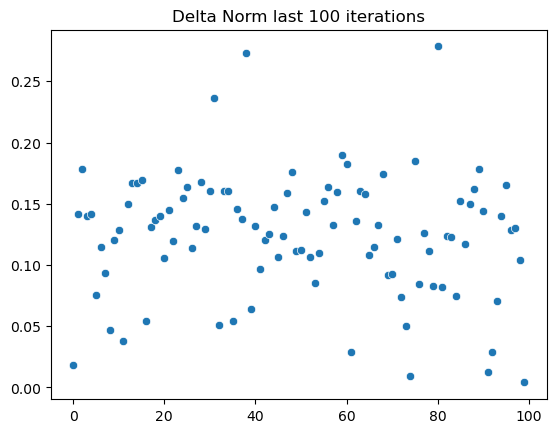

In [949]:
sns.scatterplot(delta_norm_list[len(delta_norm_list)-100:])
plt.title('Delta Norm last 100 iterations')


In [716]:
W_norm = np.linalg.norm(W_list, axis=1)

Text(0.5, 1.0, 'W Norm over time')

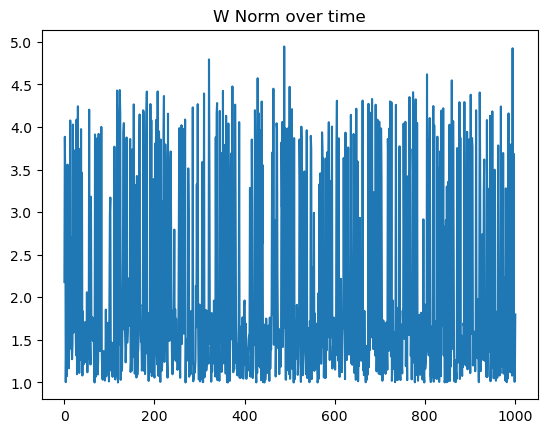

In [951]:
sns.lineplot(W_norm[::50])
plt.title('W Norm over time')

Text(0.5, 1.0, 'W Norm last 200 iterations')

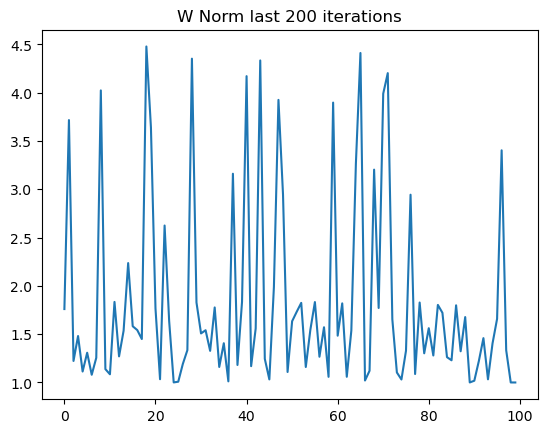

In [952]:
sns.lineplot(W_norm[len(W_norm)-100:])
plt.title('W Norm last 200 iterations')

In [953]:
distributions = [
    {"mean": np.array([-10, 10, -10]), "cov": np.eye(3)},
    {"mean": np.array([-10, -10, -10]), "cov": np.eye(3)},
    {"mean": np.array([20, 0, 20]), "cov": np.eye(3)}
]


def generate_sample2():
    """
    Randomly selects one of the three distributions with equal probability
    and generates a sample from it.

    Returns:
    - x: Generated sample (numpy array of shape (3,))
    - label: Index of the distribution (0, 1, or 2)
    """
    dist_index = random.choice(range(len(distributions)))
    dist = distributions[dist_index]
    x = np.random.multivariate_normal(mean=dist["mean"], cov=dist["cov"])
    return x

def Eig_corr_matrix(N):
    X_list = []
    eigenvals = []
    eigenvecs = []
    for i in range(N):
        x = generate_sample2()
        X_list.append(x)
    X_list = np.array(X_list)
    X_list_c = X_list - np.mean(X_list, axis=0)
    for i in range(N):
        #X_list[i] = np.array(X_list[i])
        X_T = X_list_c[i].reshape(3,1)
        C = np.dot(X_T,X_list_c[i].reshape(1,3))
        eigval, eigvec = np.linalg.eig(C)
        eigenvals.append(eigval)
        eigenvecs.append(eigvec)
    return eigenvals, eigenvecs

def find_max_eigenval_eigvec(Eigenvals,Eigenvecs):
    max_eigenvals = []
    for i in range(len(Eigenvals)):
        max_eigenvals.append(max(Eigenvals[i]))
    max_eigenval = max(max_eigenvals)
    max_eigenval_index1 = max_eigenvals.index(max_eigenval)
    max_eigenval_index2 = Eigenvals[max_eigenval_index1].argmax()
    max_eigenvec = Eigenvecs[max_eigenval_index1][max_eigenval_index2]
    return max_eigenval, max_eigenvec

def angle_between_vectors(u, v):
 
    u = np.array(u, dtype=float)
    v = np.array(v, dtype=float)
    u_norm = norm(u)
    v_norm = norm(v)
    if u_norm == 0 or v_norm == 0:
        raise ValueError("One of the vectors is zero-length.")
    cos_theta = np.dot(u, v) / (u_norm * v_norm)
    # Clip the cosine to the valid range to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg

Eigenvals,Eigenvecs = Eig_corr_matrix(100)
max_eigenval, max_eigenvec = find_max_eigenval_eigvec(Eigenvals,Eigenvecs)

angles_list = []
for i in range(len(W_list)):
    angles_list.append(angle_between_vectors(W_list[i],max_eigenvec))


<Axes: >

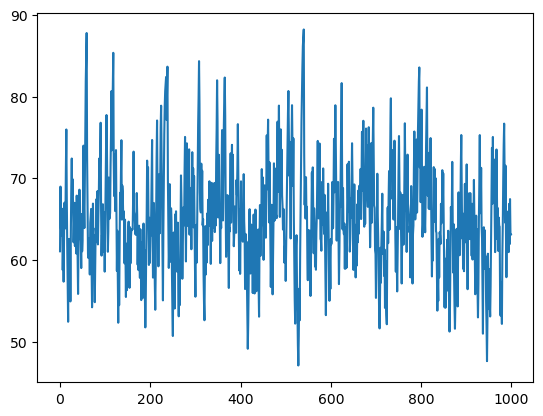

In [954]:
sns.lineplot(angles_list[len(angles_list)-1000:])

In [983]:
def compute_covariance_matrix(X):
    
    X_centered = X - np.mean(X, axis=0)
    # Compute the covariance matrix
    C = X_centered.T @ X_centered / (X.shape[0] - 1)
    return C

def compute_eigen_decomposition(C):

    eigenvals, eigenvecs = np.linalg.eig(C)
    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[sorted_indices]
    eigenvecs = eigenvecs[:, sorted_indices]
    return eigenvals, eigenvecs

def angle_between_vectors(u, v):
 
    u = np.array(u, dtype=float)
    v = np.array(v, dtype=float)
    u_norm = norm(u)
    v_norm = norm(v)
    if u_norm == 0 or v_norm == 0:
        raise ValueError("One of the vectors is zero-length.")
    cos_theta = np.dot(u, v) / (u_norm * v_norm)
    # Clip the cosine to the valid range to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    return angle_deg


X = np.array(x_list)
X_choice_indices = np.random.choice(X.shape[0], 100, replace=False)
X_choice = X[X_choice_indices]
C = compute_covariance_matrix(X_choice)
eigenvals, eigenvecs = compute_eigen_decomposition(C)
principal_eigenvec = eigenvecs[:, 0]  # First principal component
angle_deg_real = []
for w in W_list:
    angle_deg_real.append(angle_between_vectors(w, principal_eigenvec))
    #angle_deg_rand.append(angle_between_vectors(W_list, principal_eigenvec_rand))   


In [974]:
eigenvals, eigenvecs = compute_eigen_decomposition(C)

In [968]:
X_choice_indices = np.random.choice(X.shape[0], 100, replace=False)
X_choice = X[X_choice_indices]


<Axes: >

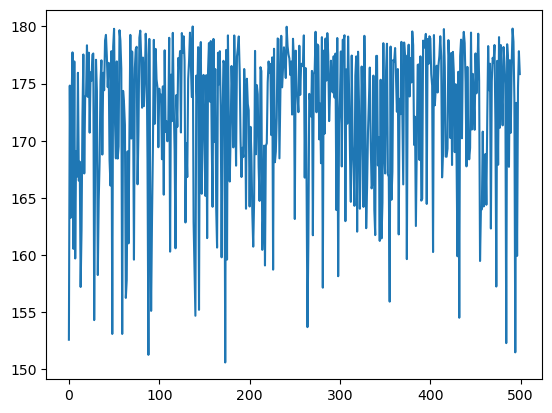

In [988]:
sns.lineplot(angle_deg_real[::1000])

<Axes: >

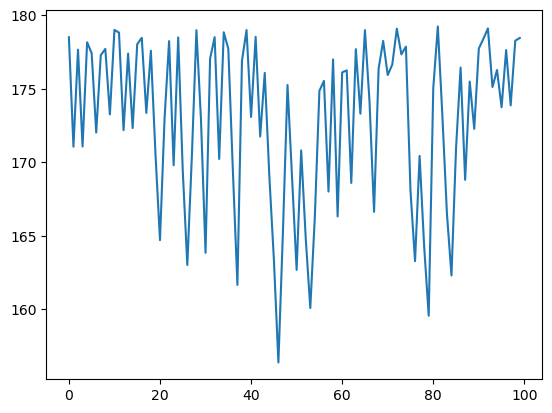

In [989]:
sns.lineplot(angle_deg[len(angle_deg)-100:])

We got what we expected- in the last iteration (the end of the Oja's online PCA), we expect the weights vector we got to be in the same or opposite direction (180 degrees) as the Principal Components of the pca. Opposite eigenvectors has the same direction and they can alter signs due to numerical computation in the code. Consequently, we got an angle close to 180 degrees in the last iteration, which means that the direction (up to a sign) of the final weights vector is closer to that of the Principal Components. 

# Q4

In [60]:
from scipy.spatial import Delaunay, ConvexHull
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm  # For progress bar

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Define the three distributions
distributions = [
    {"mean": np.array([-10, 10, -10]), "cov": np.eye(3)},
    {"mean": np.array([-10, -10, -10]), "cov": np.eye(3)},
    {"mean": np.array([20, 0, 20]), "cov": np.eye(3)}
]

def generate_sample():
    """
    Randomly selects one of the predefined distributions and generates a sample.
    
    Returns:
    - x: Generated data point (numpy array)
    - dist_index: Index of the distribution used (integer)
    """
    dist_index = random.choice(range(len(distributions)))
    dist = distributions[dist_index]
    x = np.random.multivariate_normal(mean=dist["mean"], cov=dist["cov"])
    return x, dist_index

def sanger_algorithm(
    learning_rate=0.001,
    epsilon=1e-6,
    max_iterations=1000000,
    verbose=True):
    
    
    reconstruction_error_list = []
    W_list_m1 = []
    W_list_m2 = []
    x_list = []
    labels_list = []
    W_list_m = []
    delta_1_list = []
    delta_2_list = []
    
    # Initialize two random weight vectors and normalize them
    w1 = np.random.randn(3)
    w1 /= np.linalg.norm(w1)
    w2 = np.random.randn(3)
    w2 /= np.linalg.norm(w2)
    
    if verbose:
        iterator = tqdm(range(max_iterations), desc="Training Sanger's Algorithm")
    else:
        iterator = range(max_iterations)
    
    for i in iterator:
        x, label = generate_sample()
        x_list.append(x)
        labels_list.append(label)
        
        # Compute projections onto current principal components
        y1 = np.dot(w1, x)
        y2 = np.dot(w2, x)
        
        # Compute residual for w1 (same as Oja's rule)
        delta_w1 = learning_rate * y1 * (x - y1 * w1)
        delta_1_list.append(delta_w1)
        # Compute residual for w2 considering w1
        delta_w2 = learning_rate * y2 * (x - y1 * w1 - y2 * w2)
        delta_2_list.append(delta_w2)
        
        # Update weights
        w1 += delta_w1
        w2 += delta_w2
        W_list_m1.append(w1.copy())
        W_list_m2.append(w2.copy()) 
        # Normalize weights to prevent weight explosion
        w1 /= np.linalg.norm(w1)
        w2 /= np.linalg.norm(w2)
        
        
        
        # Save current weights
        
        
        # Reconstruction Error using both principal components
        x_hat = y1 * w1 + y2 * w2
        reconstruction_error = 0.5 * np.linalg.norm(x - x_hat)**2
        reconstruction_error_list.append(reconstruction_error)
        
        # Check for convergence based on weight update magnitude
        if (np.linalg.norm(delta_w1) < epsilon) and (np.linalg.norm(delta_w2) < epsilon):
            if verbose:
                print(f"Converged after {i+1} iterations.")
            return w1, w2, i+1, x_list, reconstruction_error_list, labels_list, W_list_m1,W_list_m2, delta_1_list,delta_2_list
    
    if verbose:
        print(f"Reached maximum iterations ({max_iterations}) without full convergence.")
    return w1, w2, max_iterations, x_list, reconstruction_error_list, labels_list, W_list_m1,W_list_m2, delta_norm_list, delta_1_list,delta_2_list




# Train Sanger's algorithm to learn two principal components
W1,W2, iterations, X_train, errors, labels, W_history1,W_history2, delta_1,delta_2 = sanger_algorithm(
    learning_rate=0.0001,
    epsilon=1e-5,
    max_iterations=500000,
    verbose=True
)

print(f"Learned Principal Components (W):\n{W1}\n{W2}")
x_array = np.array(X_train)
labels_array = np.array(labels)


Training Sanger's Algorithm:  40%|███▉      | 198933/500000 [00:12<00:19, 15350.15it/s]


Converged after 198934 iterations.
Learned Principal Components (W):
[0.70677321 0.00329535 0.70743252]
[-6.22776165e-03 -9.99980280e-01  8.09108469e-04]


In [61]:
delta1_norm = np.linalg.norm(delta_1, axis=1)
delta2_norm = np.linalg.norm(delta_2, axis=1)

<Axes: >

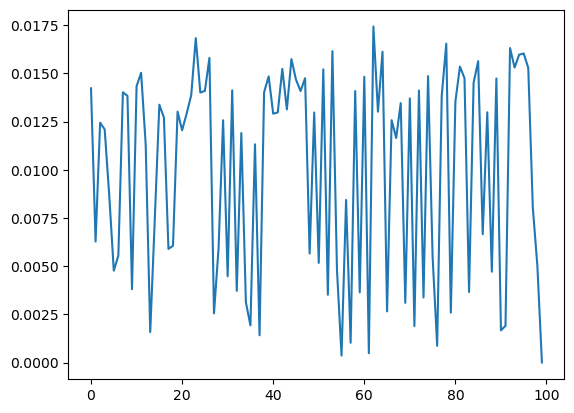

In [62]:
sns.lineplot(delta1_norm[len(delta1_norm)-100:])

<Axes: >

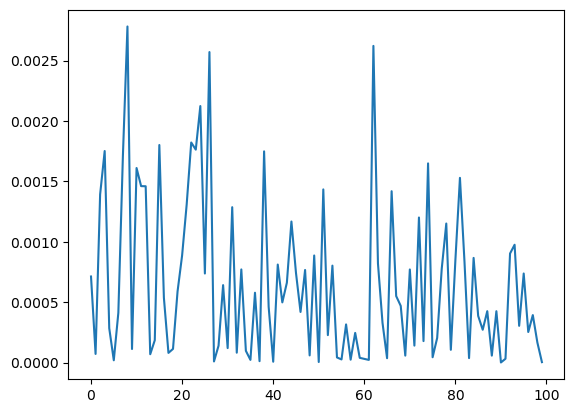

In [63]:
sns.lineplot(delta2_norm[len(delta2_norm)-100:])

<Axes: >

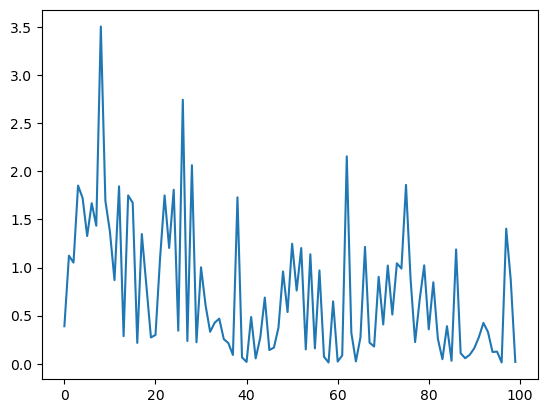

In [64]:
sns.lineplot(errors[len(errors)-100:])

In [70]:
from scipy.spatial import Delaunay, ConvexHull
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def is_point_in_hull(point, hull):

    if isinstance(hull, ConvexHull):
        hull = Delaunay(hull.points[hull.vertices])  # Convert ConvexHull to Delaunay for point checking
    return hull.find_simplex(point) >= 0

def get_secondary_direction(w_normalized):

    # Define the z-axis
    z_axis = np.array([0, 0, 1])

    # Check if w_normalized is parallel to z-axis
    if np.allclose(w_normalized, z_axis) or np.allclose(w_normalized, -z_axis):
        # If parallel, use y-axis to compute secondary direction
        y_axis = np.array([0, 1, 0])
        secondary_dir = np.cross(w_normalized, y_axis)
    else:
        # Otherwise, use z-axis
        secondary_dir = np.cross(w_normalized, z_axis)

    # Normalize the secondary direction
    secondary_dir /= np.linalg.norm(secondary_dir)

    return secondary_dir

def plot_3d_data_and_weights(data, labels, w1, w2):

    fig = plt.figure(figsize=(20, 10))

    # Normalize the principal component vectors
    w1_normalized = w1 / np.linalg.norm(w1)
    w2_normalized = w2 / np.linalg.norm(w2)

    # Compute a single secondary direction orthogonal to the first principal component
    secondary_dir = get_secondary_direction(w1_normalized)

    # =========================
    # 1. 3D Scatter Plot with Convex Hulls and Principal Components
    # =========================
    ax1 = fig.add_subplot(121, projection='3d')

    # Define colors for each cluster
    cluster_colors = {
        0: {'color': 'r', 'dark_color': 'darkred'},
        1: {'color': 'g', 'dark_color': 'darkgreen'},
        2: {'color': 'b', 'dark_color': 'beige'}
    }

    # Extract and plot each cluster
    clusters = {}
    for cluster_idx in [0, 1, 2]:
        cluster_data = data[labels == cluster_idx]
        clusters[cluster_idx] = cluster_data
        if len(cluster_data) == 0:
            print(f"No data points found for cluster {cluster_idx}.")
            continue
        ax1.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],
                    c=cluster_colors[cluster_idx]['color'], alpha=0.3,
                    label=f"Cluster {cluster_idx} ({'Red' if cluster_idx==0 else 'Green' if cluster_idx==1 else 'Blue'})",
                    s=20)

    # Compute and plot convex hulls for each cluster
    for cluster_idx, cluster_data in clusters.items():
        if len(cluster_data) < 4:
            print(f"Not enough points to compute ConvexHull for cluster {cluster_idx}.")
            continue
        try:
            hull = ConvexHull(cluster_data)
            for simplex in hull.simplices:
                ax1.plot(cluster_data[simplex, 0], cluster_data[simplex, 1],
                         cluster_data[simplex, 2], linestyle='--',
                         color=cluster_colors[cluster_idx]['color'], alpha=0.5)
        except Exception as e:
            print(f"ConvexHull for cluster {cluster_idx} could not be computed: {e}")

    # Plot the principal component lines
    max_range = np.max(np.abs(data)) * 1.2  # Slightly larger than data range
    line_points = np.linspace(-max_range, max_range, 100)
    pc_line1 = np.outer(line_points, w1_normalized)
    pc_line2 = np.outer(line_points, w2_normalized)

    ax1.plot(pc_line1[:, 0], pc_line1[:, 1], pc_line1[:, 2],
             color='k', linewidth=2, label='Principal Component 1')
    ax1.plot(pc_line2[:, 0], pc_line2[:, 1], pc_line2[:, 2],
             color='k', linewidth=2, linestyle='--', label='Principal Component 2')

    # Compute projections onto the first and second principal components
    projections1 = np.outer(np.dot(data, w1_normalized), w1_normalized)
    projections2 = np.outer(np.dot(data, w2_normalized), w2_normalized)

    # Plot projection lines for the first principal component
    for i in range(len(data)):
        cluster_idx = labels[i]
        color_dark = cluster_colors[cluster_idx]['dark_color']
        ax1.plot([data[i, 0], projections1[i, 0]],
                 [data[i, 1], projections1[i, 1]],
                 [data[i, 2], projections1[i, 2]],
                 c=color_dark, alpha=0.05, linewidth=1)

    # Plot projection lines for the second principal component
    for i in range(len(data)):
        cluster_idx = labels[i]
        color_dark = cluster_colors[cluster_idx]['dark_color']
        ax1.plot([data[i, 0], projections2[i, 0]],
                 [data[i, 1], projections2[i, 1]],
                 [data[i, 2], projections2[i, 2]],
                 c=color_dark, alpha=0.05, linewidth=1)

    # Check if the principal component vectors intersect any of the convex hulls
    intersects = {}
    for cluster_idx, cluster_data in clusters.items():
        if len(cluster_data) < 4:
            intersects[cluster_idx] = False
            continue
        hull = ConvexHull(cluster_data)
        hull_delaunay = Delaunay(cluster_data[hull.vertices])
        # Check if any point on the principal component lines is inside the convex hull
        intersects_pc1 = np.any([hull_delaunay.find_simplex(point) >= 0 for point in pc_line1])
        intersects_pc2 = np.any([hull_delaunay.find_simplex(point) >= 0 for point in pc_line2])
        intersects[cluster_idx] = intersects_pc1 or intersects_pc2

    # Compute centroids for each cluster
    centroids = {}
    for cluster_idx, cluster_data in clusters.items():
        if len(cluster_data) == 0:
            centroids[cluster_idx] = None
        else:
            centroids[cluster_idx] = cluster_data.mean(axis=0)

    # Determine 'Above' or 'Below' for each cluster and print statements
    for cluster_idx, centroid in centroids.items():
        if centroid is None:
            continue
        # Project centroid onto secondary direction
        projection_value = np.dot(centroid, secondary_dir)
        if projection_value > 0:
            position = 'Above'
        elif projection_value < 0:
            position = 'Below'
        else:
            position = 'On'

        # Check intersection
        if intersects.get(cluster_idx, False):
            print(f"Part of the principal component vector is inside the {'Red' if cluster_idx==0 else 'Green' if cluster_idx==1 else 'Blue'} cluster.")
            print(f"Part of the {'Red' if cluster_idx==0 else 'Green' if cluster_idx==1 else 'Blue'} cluster is NOT intersecting and is {position} the principal component vector.\n")
        else:
            print(f"The {'Red' if cluster_idx==0 else 'Green' if cluster_idx==1 else 'Blue'} cluster is entirely NOT intersecting and is {position} the principal component vector.\n")

    # Set plot titles and labels
    ax1.set_title("3D Data Points, Convex Hulls, and Principal Components", fontsize=15)
    ax1.set_xlabel('X1', fontsize=12)
    ax1.set_ylabel('X2', fontsize=12)
    ax1.set_zlabel('X3', fontsize=12)
    ax1.legend(loc='upper right')

    # Adjust the viewing angle for better visualization
    ax1.view_init(elev=15, azim=40)

    # Set equal aspect ratio for all axes
    ax1.set_box_aspect([1, 1, 1])


    ax2 = fig.add_subplot(122)

    # Project data onto the first two principal components
    proj_matrix = np.vstack((w1_normalized, w2_normalized)).T  # Shape (3,2)
    proj_data = data.dot(proj_matrix)  # Shape (N, 2)

    # Plot projected data points with cluster colors
    for cluster_idx in [0, 1, 2]:
        cluster_proj = proj_data[labels == cluster_idx]
        cluster_color = cluster_colors[cluster_idx]['color']
        cluster_name = 'Red' if cluster_idx == 0 else 'Green' if cluster_idx == 1 else 'Blue'
        ax2.scatter(cluster_proj[:, 0], cluster_proj[:, 1],
                    c=cluster_color, alpha=0.5,
                    label=f"Cluster {cluster_idx} ({cluster_name})", s=20)

    # Plot the principal component axis (first principal component)
    min_proj = np.min(proj_data[:, 0])
    max_proj = np.max(proj_data[:, 0])
    ax2.plot([min_proj, max_proj], [0, 0], color='k', linewidth=2, label='Principal Component Axis')

    # Determine 'Above' or 'Below' for each cluster based on the secondary direction
    for cluster_idx, cluster_data in clusters.items():
        if len(cluster_data) == 0:
            continue
        centroid = centroids[cluster_idx]
        if centroid is None:
            continue
        # Project centroid onto secondary direction
        projection_value = np.dot(centroid, secondary_dir)
        if projection_value > 0:
            position = 'Above'
        elif projection_value < 0:
            position = 'Below'
        else:
            position = 'On'
        # Get projected centroid in 2D
        projected_centroid = proj_matrix.T.dot(centroid)
        cluster_name = 'Red' if cluster_idx == 0 else 'Green' if cluster_idx == 1 else 'Blue'
        ax2.text(projected_centroid[0], projected_centroid[1],
                 f"{cluster_name} Cluster: {position}",
                 fontsize=12, color=cluster_colors[cluster_idx]['color'],
                 ha='center', va='bottom')

    # Set plot titles and labels
    ax2.set_title("2D Projection onto Principal Components", fontsize=15)
    ax2.set_xlabel('Principal Component 1', fontsize=12)
    ax2.set_ylabel('Principal Component 2', fontsize=12)
    ax2.legend(loc='upper right')

    # Draw a horizontal line representing the PCA axis
    ax2.axhline(0, color='k', linestyle='--', linewidth=1)

    # Set equal aspect ratio
    ax2.set_aspect('equal', 'box')

    plt.tight_layout()
    plt.show()


The Red cluster is entirely NOT intersecting and is Below the principal component vector.

The Green cluster is entirely NOT intersecting and is Above the principal component vector.

Part of the principal component vector is inside the Blue cluster.
Part of the Blue cluster is NOT intersecting and is Above the principal component vector.



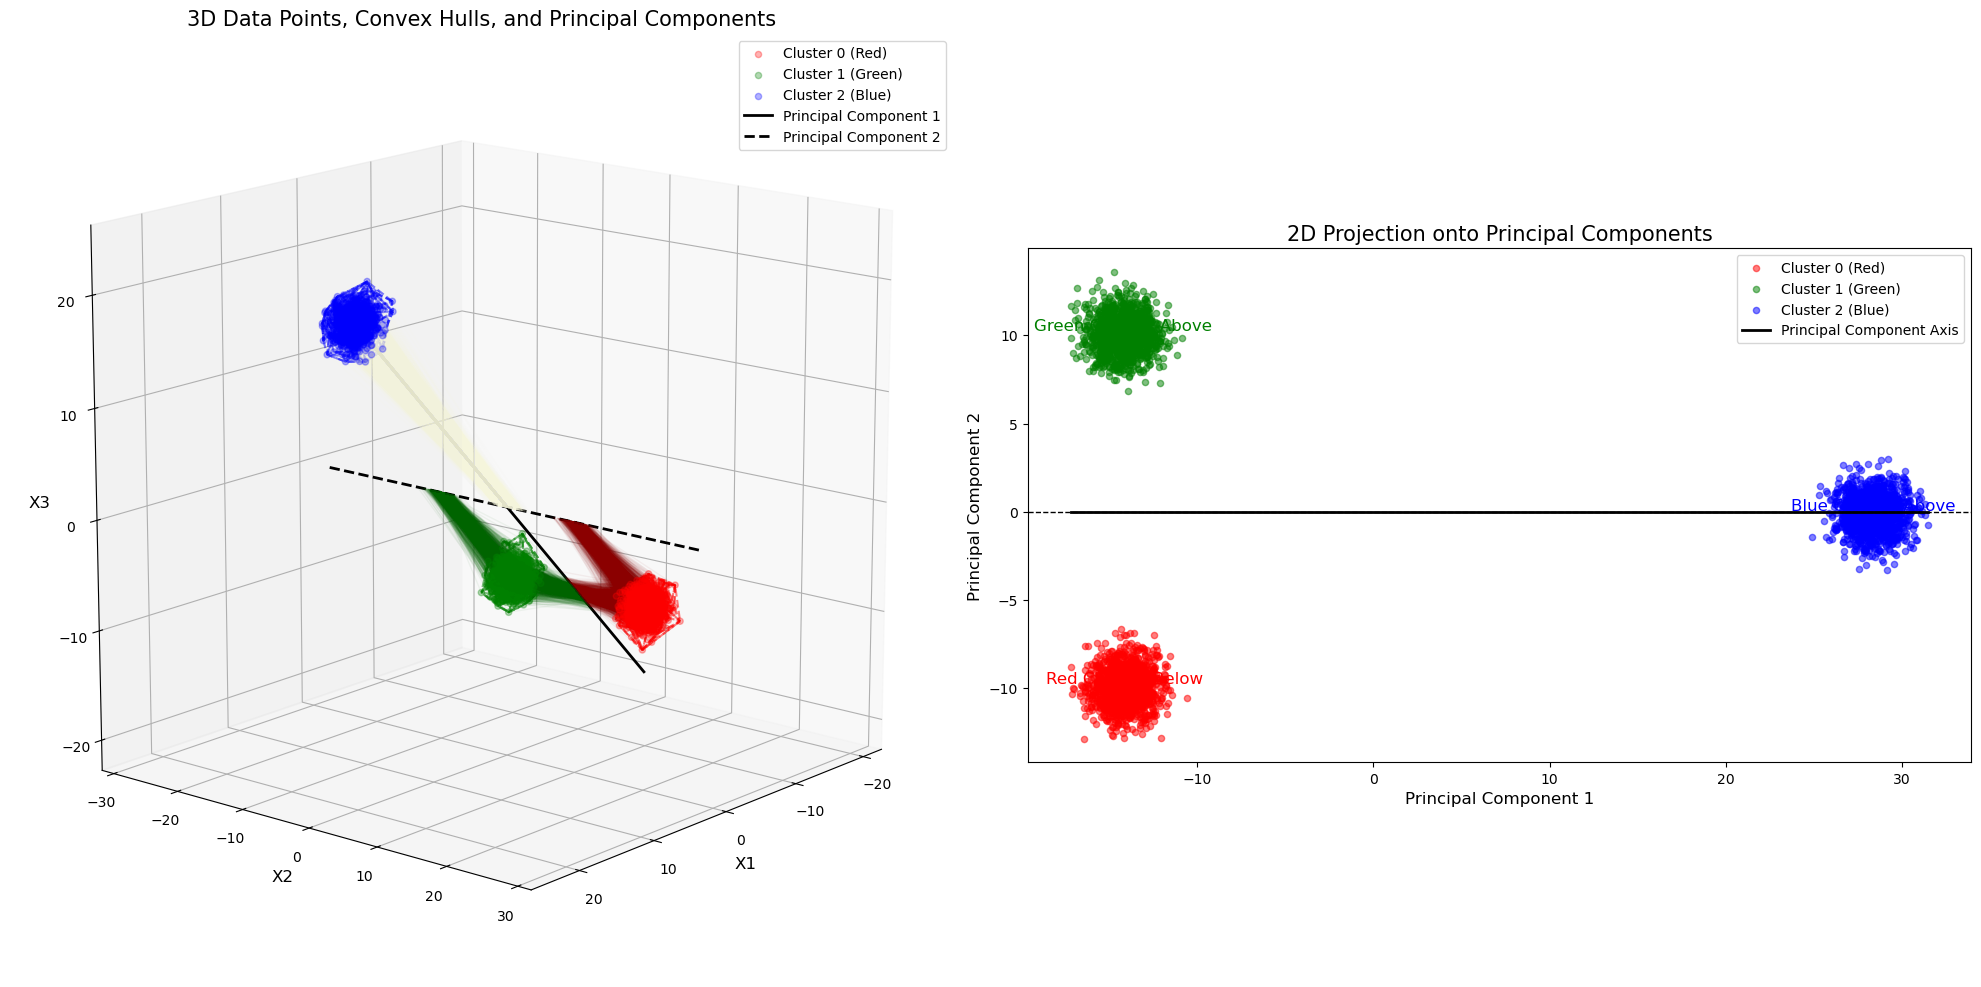

In [71]:
plot_3d_data_and_weights(x_array[::50], labels_array[::50], W1,W2)


## Let's compute the angles:

In [108]:
def compute_reconstruction_error(w1, w2, num_samples=10000):
  
    errors = []
    for _ in range(num_samples):
        x, _ = generate_sample()
        y1 = np.dot(w1, x)
        y2 = np.dot(w2, x)
        x_hat = y1 * w1 + y2 * w2
        error = np.linalg.norm(x - x_hat)**2
        errors.append(error)
    average_error = np.mean(errors)
    return average_error

def compute_covariance_matrix(X):
   
    X_centered = X - np.mean(X, axis=0)
    # Compute the covariance matrix
    C = X_centered.T @ X_centered / (X.shape[0] - 1)
    return C

def compute_eigen_decomposition(C):
   
    eigenvals, eigenvecs = np.linalg.eig(C)
    # Sort the eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[sorted_indices]
    eigenvecs = eigenvecs[:, sorted_indices]
    return eigenvals, eigenvecs

def angle_between_vectors(u, v):
   
    u = np.array(u, dtype=float)
    v = np.array(v, dtype=float)
    
    # Compute norms
    u_norm = norm(u)
    v_norm = norm(v)
    
    # Avoid division by zero
    if u_norm == 0 or v_norm == 0:
        raise ValueError("One of the vectors is zero-length.")
    
    # Compute cosine of the angle
    cos_theta = np.dot(u, v) / (u_norm * v_norm)
    
    # Clip cosine to the valid range to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Compute the angle in radians and then convert to degrees
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    
    # Ensure the angle is the smallest possible (<= 90 degrees)
   
    return angle_deg


X = np.array(X_train)
X_choice_indices = np.random.choice(X.shape[0], 100, replace=False)
X_choice = X[X_choice_indices]
C = compute_covariance_matrix(X_choice)
eigenvals, eigenvecs = compute_eigen_decomposition(C)
principal_eigenvec1 = eigenvecs[:, 0]  # First principal component
principal_eigenvec2 = eigenvecs[:, 1]  # Second principal component

angle_deg_real1 = []
angle_deg_real2 = []
for w1 in W_history1:
    angle_deg_real1.append(angle_between_vectors(w1, principal_eigenvec1))
for w2 in W_history2:
    angle_deg_real2.append(angle_between_vectors(w2, principal_eigenvec2))


In [120]:
angle_between_vectors(W1, W2)

90.40820802018943

Text(0.5, 0.98, 'Angle W1 vs First Principal Component over time')

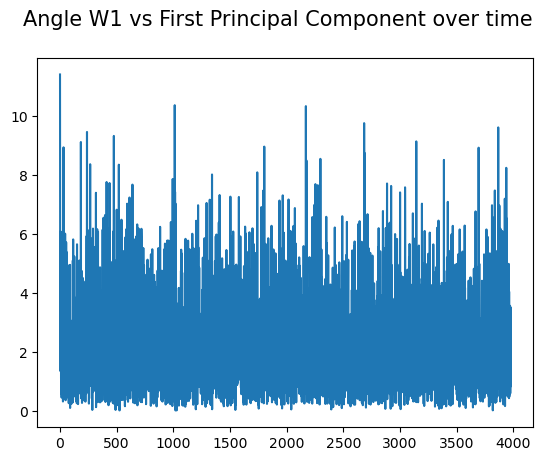

In [126]:
sns.lineplot(angle_deg_real1[::50])
plt.suptitle('Angle W1 vs First Principal Component over time', fontsize=15)

Text(0.5, 0.98, 'Angle  W1 vs First Principal Component last 100 iterations')

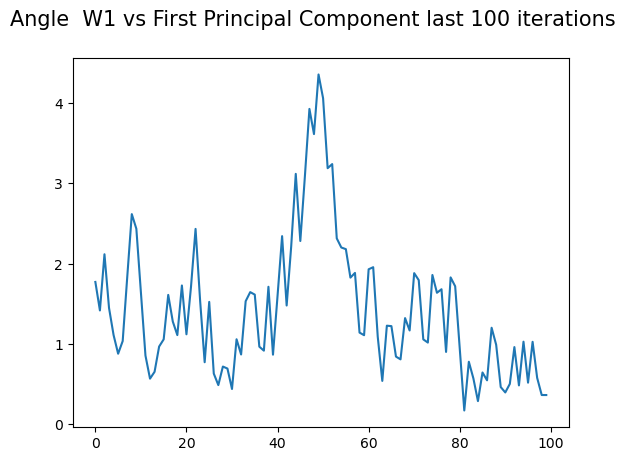

In [125]:
sns.lineplot(angle_deg_real1[len(angle_deg_real1)-100:])
plt.suptitle('Angle  W1 vs First Principal Component last 100 iterations', fontsize=15)

In [111]:
angle_between_vectors(W1,W2)

90.40820802018943

Text(0.5, 0.98, 'Angle W2 vs Second Principal Component over time')

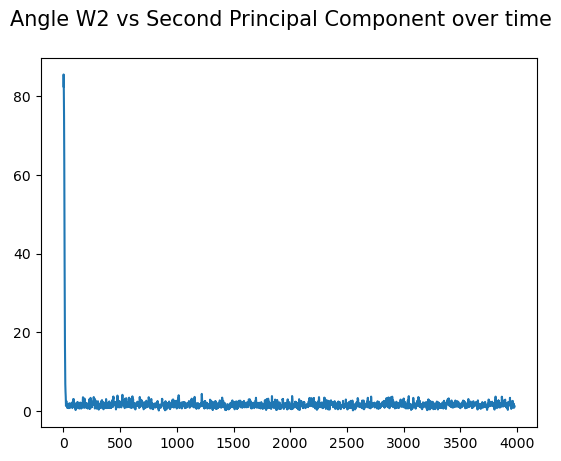

In [124]:
sns.lineplot(angle_deg_real2[::50])
plt.suptitle('Angle W2 vs Second Principal Component over time', fontsize=15)

Text(0.5, 0.98, 'Angle W2 vs Second Principal Component last 100 iterations')

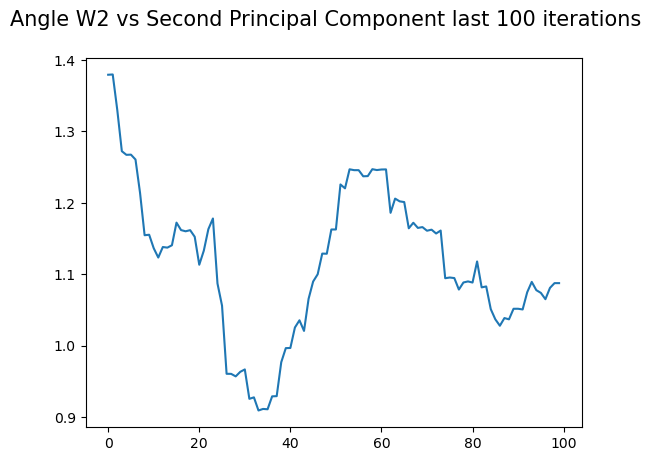

In [127]:
sns.lineplot(angle_deg_real2[len(angle_deg_real2)-100:])
plt.suptitle('Angle W2 vs Second Principal Component last 100 iterations', fontsize=15)

**We got what we expected:**

1. degree between W1 and W2 (eigenvectors in the prediction) is approximately 90
2. degrees between the online PCA and offline PCA are close to 0 